# Training Script for training 
with your own dataset and optional with predefined shape parameters in coarse mode

In [2]:
#Imports
from decalib.deca import DECA
from decalib.datasets import datasets 
from decalib.utils import util
from decalib.utils.config import cfg as deca_cfg
from skimage.io import imread
from tqdm import tqdm
import torch
import numpy as np
import mediapipe as mp
import os
import cv2
import trimesh
import matplotlib.pyplot as plt
import logging
import ipywidgets as widgets
from IPython.display import display
import DePa

1. Prepare datset

    a. Use your own dataset

    b. Use a Dataset which DECA used, like VGGFace2Hq

- In .decalib/datasets/"dataset you use" define paths to datafile + shape and landmark folders (we will build them)

1. 1. Get the landmarks for every image

Infos: image folder should have the structure ./person/imagename."suffix"

While Landmarking also images that are not valid will not be used

Not valid: Images with less than half of the landmarks. Images with more than one person or no person can be detected

In [10]:
# Defining Paths

basefolder = '/home/dietrich/Testing/DECA/Dataset/Probanden'
images_folder = os.path.join(basefolder, 'Probanden/')
lmks_folder = os.path.join(basefolder, 'lmks_train/')
os.makedirs(lmks_folder, exist_ok=True)
shape_folder = os.path.join(basefolder, 'shape_train/')
os.makedirs(shape_folder, exist_ok=True)
images_per_person = 9
total_steps = 27 #Number of individuals


In [11]:
img_name_list = []

counter = 0

progress_slider = widgets.IntSlider(min=0, max=total_steps, value=counter, description='Progress')
logging.basicConfig(filename=os.path.join(basefolder, f'lmks_and_shape_processing_{images_per_person}_imgs.log'), level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def update_slider(value):
    progress_slider.value = value
display(progress_slider)

lms_478_to_68 = [
                162,234,93,58,172,136,149,148,152,377,378,365,397,288,323,454,389,71,63,105,66,107,336,
                296,334,293,301,168,197,5,4,75,97,2,326,305,33,160,158,133,153,144,362,385,387,263,373,
                380,61,39,37,0,267,269,291,405,314,17,84,181,78,82,13,312,308,317,14,87
            ]

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(
                static_image_mode = True,
                max_num_faces = 1,
                refine_landmarks=False,
                )

expected_landmarks_count = 34 # Half should be detected
# Through all folders in the Dataset Path
for individ__name in os.listdir(images_folder):
    individ__path = os.path.join(images_folder, individ__name)

    if os.path.isdir(individ__path):
        lmks_individ_path = os.path.join(lmks_folder, individ__name)
        if not os.path.exists(lmks_individ_path):
            os.makedirs(lmks_individ_path)
        # counting valid images and break, if enough images are taken
        img_list_individual = []
        # For one individual (one folder) going through the images, until 6 are detected
        for image_name in os.listdir(individ__path):
            image_path = os.path.join(individ__path, image_name)

            if image_name.lower().endswith(('.jpg', '.png')):
                fn, ext = os.path.splitext(os.path.basename(image_name))

                #Process Mediapipe
                image = cv2.imread(image_path)
                image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype('uint8')

                results = face_mesh.process(image_rgb)
                
                # Excactly one person should be detected, else the image is not used
                if results.multi_face_landmarks and len(results.multi_face_landmarks) == 1:
                    landmarks = results.multi_face_landmarks[0].landmark
                    selected_lm = [landmarks[i] for i in lms_478_to_68] 
                    selected_lm = [[lm.x * image.shape[1], lm.y * image.shape[0]] for lm in selected_lm]

                    # Half of the face need to be detected, else another image is used
                    if len(selected_lm) >= expected_landmarks_count:
                        np.save(os.path.join(lmks_individ_path, fn + "_68kpts.npy") ,selected_lm)
                        img_list_individual.append(os.path.join(individ__name, fn))
                    else:
                        logging.info(f'Not used: Detected less than 35 Landmarks: {individ__path}/{image_name}')
                else:
                    logging.info(f'Not used: Detected none or more than one face: {individ__path}/{image_name}')

            #If we got all Images, the next individual will be landmarked
            if len(img_list_individual) == images_per_person:
                img_name_list.append(img_list_individual)
                np.save(os.path.join(basefolder, f"data_names_{images_per_person}_per_individual"), img_name_list)
                break
    counter +=1
    update_slider(counter)


    
print("Landmark Detection and Image Selection Done")

IntSlider(value=0, description='Progress', max=27)

I0000 00:00:1706297922.934026 3694057 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1706297922.945027 3764354 gl_context.cc:344] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.154.05), renderer: NVIDIA GeForce GTX TITAN X/PCIe/SSE2
[ WARN:0@632.857] global loadsave.cpp:248 findDecoder imread_('/home/dietrich/Testing/DECA/Dataset/Probanden/Probanden/Proband_3/Proband_3_05.jpg'): can't open/read file: check file path/integrity


error: OpenCV(4.8.1) /io/opencv/modules/imgproc/src/color.cpp:182: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


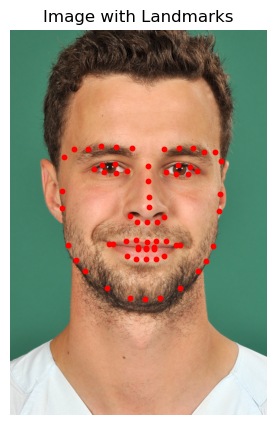

In [17]:
def show_image_with_landmarks(image_path, landmarks):
    # Bild laden
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Figure erstellen
    fig, ax = plt.subplots(figsize=(5, 5))

    # Bild mit Landmarks zeichnen
    ax.imshow(img_rgb)
    ax.scatter(*zip(*landmarks), s=10, c='r')
    ax.set_title('Image with Landmarks')

    # Achsen deaktivieren
    ax.axis('off')

    # Bild anzeigen
    plt.show()

import random
random_img = random.randint(0, images_per_person)
random_ind = random.randint(0, total_steps)
# Beispielaufruf für ein ausgewähltes Bild
selected_image_path = os.path.join(images_folder, img_name_list[random_ind][random_img] + '.JPG')
selected_landmarks = np.load(os.path.join(lmks_folder, img_name_list[random_ind][random_img] + "_68kpts.npy"))
# Funktion aufrufen
show_image_with_landmarks(selected_image_path, selected_landmarks)

1. 2. Get Shape Parameters

In [18]:
# Load the datafile
datafile_path = os.path.join(os.path.join(basefolder, f"data_names_{images_per_person}_per_individual.npy"))
data_list = np.load(datafile_path).astype('str')

In [24]:
progress_slider = widgets.IntSlider(min=0, max=data_list.shape[0], value=counter, description='Progress')

def update_slider(value):
    progress_slider.value = value
display(progress_slider)
counter = 0

for idx in range(data_list.shape[0]):
    # Building paths to images
    folder_path = os.path.join(shape_folder, data_list[idx, 0].split('/')[0])
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    imagepath = [os.path.join(images_folder, data_name + '.JPG') for data_name in data_list[idx, :]]
    shape_array = []
    # for every image save the shape parameters
    for i in range(len(imagepath)):
        #Running deca and encoding with the default deca trained model
        codedict = DePa.run_deca(imagepath[i], only_encode=True)
        np.save(shape_folder + '/' + data_list[idx, i] + '.npy', codedict['shape'].cpu().numpy())
        shape_array.append(codedict['shape'].cpu().numpy())
    # Save the mean shape parameters
    mean_shape = np.mean(np.array(shape_array), axis=0)
    np.save(os.path.join(shape_folder, data_list[idx, 0].split('/')[0], data_list[idx, 0].split('/')[0]+'_shape_mean.npy'), mean_shape)

    counter +=1
    update_slider(counter)


IntSlider(value=18, description='Progress', max=26)

1. 3. Divide in Training and Validation Images

In [34]:
datafile_path = os.path.join(os.path.join(basefolder, f"data_names_{images_per_person}_per_individual.npy"))
data_list = np.load(datafile_path).astype('str')

val_img_num = 20

data_list_valid = data_list[:val_img_num, :]

data_list_train = data_list[val_img_num:, :]

valid_path = os.path.join(basefolder, f'data_names_{images_per_person}_per_individual_valid.npy')
np.save(valid_path, data_list_valid)
train_path = os.path.join(basefolder, f'data_names_{images_per_person}_per_individual_train.npy')
np.save(train_path, data_list_train)


2. Training DECA Model

In [4]:
import os
import glob

def find_files_with_extension(root_folder, extension):
    pattern = os.path.join(root_folder, f'**/*.{extension}')
    files = glob.glob(pattern, recursive=True)
    return files

def rename_and_capitalize(files):
    for file_path in files:
        # Extrahiere Verzeichnis und Dateinamen
        directory, filename = os.path.split(file_path)

        # Ändere den ersten Buchstaben des Dateinamens zu Großbuchstaben
        new_filename = filename.capitalize()

        # Erstelle den neuen Dateipfad mit dem geänderten Dateinamen
        new_file_path = os.path.join(directory, new_filename)

        # Umbenennen der Datei
        os.rename(file_path, new_file_path)

# Beispielaufruf:
root_folder = '/home/dietrich/Testing/DECA/Dataset/Probanden/Probanden'
extension = 'jpg'

jpg_files = find_files_with_extension(root_folder, extension)

# Umbenennen aller Dateien in der Liste zu .jpg
rename_and_capitalize(jpg_files)